# Project Outline
**Methodology:** for that matter, a [CRISP-DM](https://www.sv-europe.com/crisp-dm-methodology/) approach will be used to cover the following main parts:  
- **Business Understanding:** understanding of how are the operations, how the data can be used to support them and what are the main objectives of the project.
- **Data Understanding & Preparation:** explore the data to observe the available information, any potential problems and constraints. In addition, any data related issues discovered here will be addressed as the data is ultimately prepared for modeling.
- **Data Modeling:** test different modeling approaches and optimize the one(s) with a better initial performance.
- **Evaluate the Results:** evaluate the results produced by the optimized classifier and understand how the outputs can best support the business.

The first two steps were performed in the `Starbucks_Capstone_notebook_part1.ipynb` file. The last two will be performed here.

Before continuing, let's first review the business problems and objectives.

# Business Understanding

The dataset portraits a common retailer scenario, where the company sends out offers to its customers in order to keep them engaged and maintain its customer base. As mentioned earlier, this is a simplification of the regular data Starbucks has, but nonetheless the principles and logic behind organizing, cleaning and modeling could also be applied in a real case.

With that in mind, below are the main points to discuss before we start the analysis:

**Goal: The current project aims to model predict if an offer will be successful given customer demographic information, as well as some of the offer's characteristics.** For that, 2 tables will be used: one containing the similar offers of `BOGO` (buy one and get one), as well as `discount`; and a second containing `informational` offers. The criterias to identify a successful offer are:

- **BOGO & discount offers:** for these offers to be considered successful, these events need to happen in sequence:
- > **offer received >> offer viewed >> transaction >> offer completed**

If these events take place in sequence for the same offer, we will consider it successful and our target for it will be `1`.

- **informational offer:** in this case we will need to observe the following:
- > **offer received >> offer viewed >> transaction**

If these events are seen in this order AND the transaction takes place during the influence period of the offer (variable `duration`), we will consider it successful and the target will also be `1`.

For all other scenarios, the offers will be considered unsuccessful and the target will be `0`.

Given these parameters, this is a supervised classification problem and, as such, potential metrics to evaluate the task's success are:
- [`accuracy score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html): according to the Scikit-Learn documentation, _the accuracy_score function computes the accuracy, either the fraction (default) or the count (normalize=False) of correct predictions._ This metric is widely used in such classification problems and it's best used for more balanced datasets (when the number of positive and negative cases are similar).
- [`f1 score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html): similarly, the F1 Score also evaluates the performance of the classifier, but as it takes into account both precision (_the ability of the classifier not to label as positive a sample that is negative_) and recall (_the ability of the classifier to find all the positive samples_), it normally has more evaluation power in unbalanced datasets. In fact, this is the harmonic mean of precision and recall and is defined as: `F1 = 2 * (precision * recall) / (precision + recall)`  Source: Scikit-Learn Documentation.

For both metrics, the higher, the better.

Now that we have reviewed the task at hand, let's continue with part 2!

# Imports

In [70]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import (confusion_matrix, classification_report, f1_score,
                             accuracy_score, recall_score, roc_auc_score,
                             roc_curve, precision_score, auc)

pd.options.display.max_columns=100

def plot_roc_curve(fpr, tpr, y_true, y_score):
    plt.title('Receiver Operating Characteristic: {:.3}'.format(roc_auc_score(y_true, y_score)))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7")
    plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Data load

In [4]:
bogodis = pd.read_csv('data/bogodis.csv')
print(bogodis.shape)
print(bogodis.offer_successful.value_counts())
bogodis.head()

(61042, 26)
0    36834
1    24208
Name: offer_successful, dtype: int64


,person,offer_id,received_id,offer_successful,sum_event_offer_received,sum_event_offer_viewed,sum_event_transaction,sum_event_offer_completed,sum_amount,mean_difficulty,mean_amount,count_received_id,channel_email,channel_mobile,channel_social,channel_web,age,income,gender_F,gender_M,gender_O,gender_Unknown,year,month,day,week
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,0,3,2,7,3,105.44,8.125,7.029333,3.0,1.0,1.0,0.0,1.0,33,72000.0,0,1,0,0,2017,4,21,16
1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,3.0,0,3,2,7,3,105.44,8.125,7.029333,3.0,1.0,1.0,1.0,1.0,33,72000.0,0,1,0,0,2017,4,21,16
2,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,4.0,1,3,2,7,3,105.44,8.125,7.029333,3.0,1.0,1.0,1.0,1.0,33,72000.0,0,1,0,0,2017,4,21,16
3,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,2,2,3,0,4.09,5.000,0.584286,2.0,1.0,1.0,1.0,1.0,118,0.0,0,0,0,1,2018,4,25,17
4,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,6.0,0,2,2,3,0,4.09,5.000,0.584286,2.0,1.0,1.0,1.0,1.0,118,0.0,0,0,0,1,2018,4,25,17


In [5]:
informational = pd.read_csv('data/informational.csv')
print(informational.shape)
print(informational.offer_successful.value_counts())
informational.head()

(15235, 26)
0.0    9473
1.0    5762
Name: offer_successful, dtype: int64


,person,offer_id,received_id,offer_successful,sum_event_offer_received,sum_event_offer_viewed,sum_event_transaction,sum_event_offer_completed,sum_amount,mean_difficulty,mean_amount,count_received_id,channel_email,channel_mobile,channel_social,channel_web,age,income,gender_F,gender_M,gender_O,gender_Unknown,year,month,day,week
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,0.0,2,2,1,0,22.16,0.0,4.432,2.0,1.0,1.0,0.0,1.0,33,72000.0,0,1,0,0,2017,4,21,16
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,2.0,1.0,2,2,1,0,22.16,0.0,4.432,2.0,1.0,1.0,1.0,0.0,33,72000.0,0,1,0,0,2017,4,21,16
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,9.0,0.0,2,2,1,0,13.49,0.0,2.698,2.0,1.0,1.0,0.0,1.0,40,57000.0,0,0,1,0,2018,1,9,2
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,10.0,0.0,2,2,1,0,13.49,0.0,2.698,2.0,1.0,1.0,1.0,0.0,40,57000.0,0,0,1,0,2018,1,9,2
4,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,13.0,0.0,1,1,3,0,64.67,0.0,12.934,1.0,1.0,1.0,1.0,0.0,59,90000.0,1,0,0,0,2016,3,4,9


Both datasets were organized in part 1 and they both present the same features for modeling.

In our approach, different models will be tested on the data with default parameters. The best performing one will be optimized so we can improve our metrics.

Important to note that some features were organized with a tree-based model in mind. Such features are `year`, `month`, `week` and `day`. Each one has the period in which the customer has become a member. Together, they used to form the variable `became_member_on`, which was a time stamp. Note that for linear models, a more common approach would be to create dummy variables for at least `year` and `month`, since we wouldn't greatly increase the feature space. As `week` and `day` have many possible values, creating dummies out of them would increase the dimensions of the table without necessarily providing more information. Tree-based models make axis parallel partitions in the data and, thus, dummies are not necessary.

Nonetheless, some linear models will be tested on the data to provide us a reference of how they could perform.

The models that will be tested are:
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)
- [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [XGBoost Classifier](https://xgboost.readthedocs.io/en/latest/)

`Dummy Classifier` will be used as a benchmark, as it will always yield the `most frequent value` in the data (this is the selected strategy)

# 1ST MODELING TASK: `BOGO` and `discount` offers

## partition: `BOGO` and `discount` offers
This will be done twice, as we have 2 different datasets. Let's start with the `bogodis` dataset, which has both the `BOGO` and `discount` offers.

In [6]:
X = bogodis.drop(['person', 'offer_id', 'received_id', 'offer_successful'], axis=1)
y = bogodis['offer_successful']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((42729, 22), (18313, 22))

## Test out-of-the-box models: `BOGO` and `discount` offers

Let's see how the selected models perform in the data with no parameter tunning. `random_state` will be set, though, so the results are reproducible.

In [8]:
seed = 42

clfs = [SVC(random_state=seed),
        LogisticRegression(random_state=seed),
        DummyClassifier(strategy='most_frequent', random_state=seed),
        RandomForestClassifier(random_state=seed),
        XGBClassifier(random_state=seed)]

f1_dict = dict()
accuracy_dict = dict()

for clf in clfs:
    name = clf.__class__.__name__
    
    if name in ['SVC', 'LogisticRegression']:
        scaler = QuantileTransformer()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled  = scaler.transform(X_test)
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    
    # record results
    f1_dict[name] = f1_score(y_test, y_pred)
    accuracy_dict[name] = accuracy_score(y_test, y_pred)

/Users/gabrielestivalet/anaconda/envs/snakes/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/gabrielestivalet/anaconda/envs/snakes/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [9]:
f1_dict

{'SVC': 0.7750940814231955,
 'LogisticRegression': 0.7592707258341933,
 'DummyClassifier': 0.0,
 'RandomForestClassifier': 0.6873859969131472,
 'XGBClassifier': 0.7815966041352869}

In [10]:
accuracy_dict

{'SVC': 0.8205100202042265,
 'LogisticRegression': 0.8089335444766014,
 'DummyClassifier': 0.6033964942936711,
 'RandomForestClassifier': 0.7566755856495386,
 'XGBClassifier': 0.8258068039097909}

In [36]:
y.mean()

0.39657940434454964

As we can see, `xgboost` has performed better than all other models. Normally, this model outperforms most algorithm but it is not necessarily always the best choice for all problems.

Curiously, Both `SVC` and `Logistic Regression` have performed almost as good as `xgboost`. This could indicate that perhaps some more feature engineering and model testing could be made in future iterations.

Finally, as the dataset is fairly balanced, both `accuracy` and `f1_score` present high values out-of-the-box. The exception would be the `DummyClassifier` that scores low in `accuracy` and `0` according to `f1_score`. In fact, this metric will always have a value of `0` for a classifier that predicts a constant value.

Let's proceed for optimization and further evaluations.

## Optimize best model: `BOGO` and `discount` offers
For the optimization, a modest parameter search will be provided to a `RandomizedSearchCV` meta-estimator combined with a 5-fold cross-validation to help avoid overfitting and properly tuning the model.

In [14]:
xgb = XGBClassifier(objective='binary:logistic',
                    booster='gbtree')

parameters = {'max_depth':[3,5,7,10],
             'learning_rate':[0.001,0.01,0.1,1,10],
             'n_estimators':[50,100,300,500],
             'gamma':[0.01,1,10],
             'reg_alpha':[0.01,1,10],
             'colsample_bytree':[0.3, 0.5]}

search = RandomizedSearchCV(xgb, param_distributions=parameters,
                            n_iter=50,
                            n_jobs=-1,
                            cv=5,
                            random_state=seed,
                            verbose=1)

search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 12.1min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'max_depth': [3, 5, 7, 10], 'learning_rate': [0.001, 0.01, 0.1, 1, 10], 'n_estimators': [50, 100, 300, 500], 'gamma': [0.01, 1, 10], 'reg_alpha': [0.01, 1, 10], 'colsample_bytree': [0.3, 0.5]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

## Optimized classifier evaluation: `BOGO` and `discount` offers
After running a moderately simple round of optimization, these are the results we can observe:

In [31]:
y_pred = search.predict(X_test)
print(f'f1_score: {f1_score(y_test, y_pred):.4f}')
print(f'accuracy_score: {accuracy_score(y_test, y_pred):.4f}')

f1_score: 0.7853
accuracy_score: 0.8296


As we can see, the results have virtually stayed the same. Can can signal that the model would need some more feature engineering before return better results, or simply that it need to be better optimized. 

In general, the second approach would be be tested first at this point, as the computing time is not so expensive nowadays. Therefore, with bigger parameter searches and more iterations, it is likely that the results would improve further.

Nevertheless, let's continue to evaluate the model.

In [30]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.86      0.86      0.86     11050
          1       0.78      0.79      0.79      7263

avg / total       0.83      0.83      0.83     18313



/Users/gabrielestivalet/anaconda/envs/snakes/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Here we can see the precision, recall and f1_score for each target (positive and negative). The model seems to be able to better identify the negative cases than the positive ones, as all metrics for class `0` are higher. Reasons for that could be the slight imbalance in between positive and negative cases, which is not very significant. Another explanation could be that the positive cases are simply more difficult to identify, resulting in lower scores.

In [26]:
confusion_matrix(y_test, y_pred)

array([[9486, 1564],
       [1556, 5707]])

On the main diagonal (from top-left to bottom-right) we can see the correctly classifierd samples. The other diagonal shows the classification errors, which are about the same for type I and II errors.

***XGB-train***


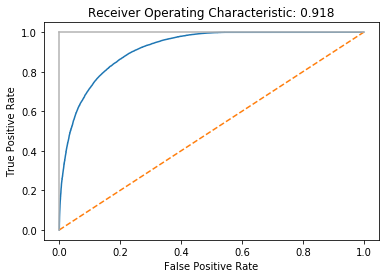

In [61]:
y_pred_proba_train = search.predict_proba(X_train)[:,1]

# Create true and false positive rates
print('***XGB-train***')
fpr, tpr, threshold = roc_curve(y_train, y_pred_proba_train)
plot_roc_curve(fpr, tpr, y_train, y_pred_proba_train)

***XGB-test***


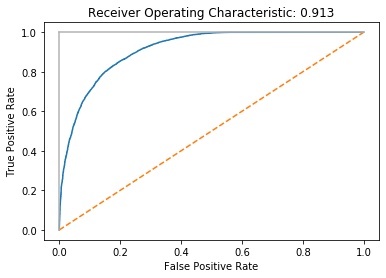

In [60]:
y_pred_proba = search.predict_proba(X_test)[:,1]

# Create true and false positive rates
print('***XGB-test***')
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
plot_roc_curve(fpr, tpr, y_test, y_pred_proba)

One widely used metric for evaluating classifier (specially for unbalanced cases) is the Area Under the ROC Curve, which has a scale from 0.5 to 1, being 1 the best possible outcome.

According to the scikit-learn documentation: 
- > _A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate._” [sklearn-roc-metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics).

Therefore, it evaluates all possible errors and it makes a better assessment of the results when accuracy might fail due to class imbalance.

The value of `0.913` if quite good and not easily seen in real-life situations, where models with a score above 0.85 are generally considered for production for many uses. There are always situations where the model needs to perform exceptionally well before its use is considered. This can happen in areas such as aviation, medical and manufacturing.

In [ ]:
# Saving the model
filename = 'models/bogo_discount_model.sav'
pickle.dump(search.best_estimator_, open(filename, 'wb'))

In [7]:
# Loading the model
filename = 'models/bogo_discount_model.sav'
search = pickle.load(open(filename,'rb'))
search

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=10, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=nan, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

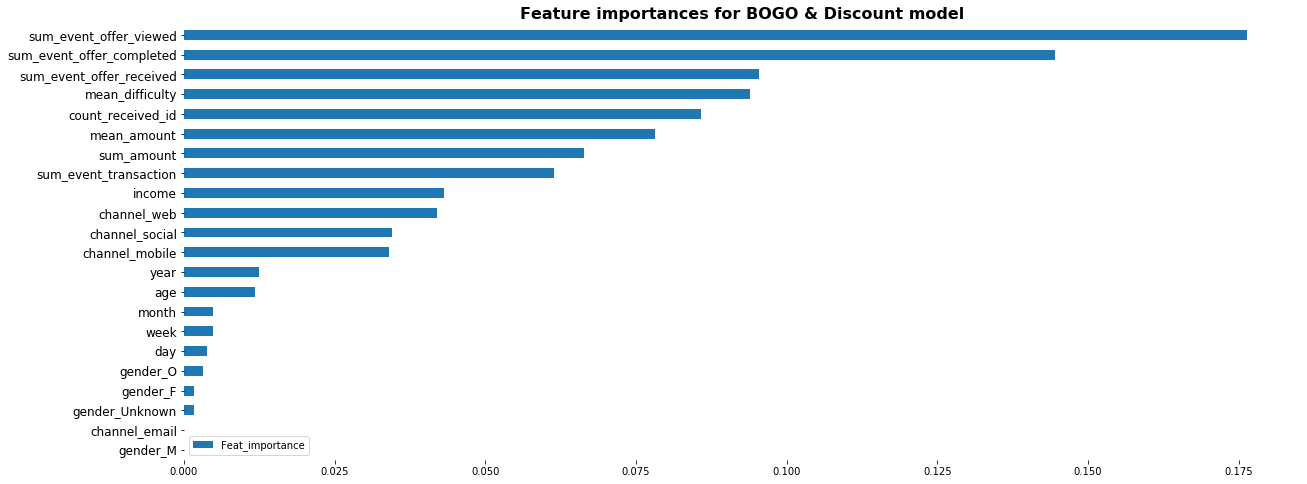

In [22]:
def plot_feature_importances(model, data, tit):
    """
    Plot feature importance for all features in the data.
    The feature importances are available for most tree-based models.
    """
    features = {}
    for feature, importance in zip(data.columns, model.feature_importances_):
        features[feature] = importance

    importances = ((pd.DataFrame.from_dict(features, orient='index')
                                .rename(columns={0: 'Feat_importance'}))
                   .sort_values(by='Feat_importance').tail(30))

    fig, ax = plt.subplots(figsize=(20,8))
    importances.plot(kind='barh', rot=0, ax=ax)
    
    # format
    for sp in ['top', 'right', 'bottom', 'left']:
        ax.spines[sp].set_visible(False)
        
    plt.title(tit, fontsize=16, fontweight='bold')
    plt.yticks(fontsize=12)
    plt.show()
    
plot_feature_importances(search, data=X_train, tit="Feature importances for BOGO & Discount model")

The sum of offers received, viewed and completed seems to be among the most informative features, whereas gender, age and time since becoming a member rank low in the feature importances.

As there were differences between genders, I would expect to see a higher importance being attributed to gender. Moreover, email_channel seem to be not informative at all, while other channels have more discriminatory power according to the classifier.

# 2ND MODELING TASK: `informational` offers

## partition: `informational` offers
Finally, the second partition for the `informational` table.

In [25]:
X2 = informational.drop(['person', 'offer_id', 'received_id', 'offer_successful'], axis=1)
y2 = informational['offer_successful']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify=y2, test_size=0.3, random_state=42)
X_train2.shape, X_test2.shape

((10664, 22), (4571, 22))

## Test out-of-the-box models: `informational` offers
Once again, `random_state` will be set so the results are reproducible. Let's see how the models perform without any parameter tunning:

In [17]:
seed = 42

clfs = [SVC(random_state=seed),
        LogisticRegression(random_state=seed),
        DummyClassifier(strategy='most_frequent', random_state=seed),
        RandomForestClassifier(random_state=seed),
        XGBClassifier(random_state=seed)]

f1_dict2 = dict()
accuracy_dict2 = dict()

for clf in clfs:
    name = clf.__class__.__name__
    
    if name in ['SVC', 'LogisticRegression']:
        scaler = QuantileTransformer()
        scaler.fit(X_train2)
        X_train_scaled2 = scaler.transform(X_train2)
        X_test_scaled2  = scaler.transform(X_test2)
        clf.fit(X_train_scaled2, y_train2)
        y_pred2 = clf.predict(X_test_scaled2)
    else:
        clf.fit(X_train2, y_train2)
        y_pred2 = clf.predict(X_test2)
    
    # record results
    f1_dict2[name] = f1_score(y_test2, y_pred2)
    accuracy_dict2[name] = accuracy_score(y_test2, y_pred2)

In [18]:
f1_dict2

{'SVC': 0.7467720685111989,
 'LogisticRegression': 0.7007760850819201,
 'DummyClassifier': 0.0,
 'RandomForestClassifier': 0.6668594563331406,
 'XGBClassifier': 0.7398749660233759}

In [19]:
accuracy_dict2

{'SVC': 0.7897615401443885,
 'LogisticRegression': 0.7722598993655655,
 'DummyClassifier': 0.6217457886676876,
 'RandomForestClassifier': 0.7479763727849486,
 'XGBClassifier': 0.7906366221833296}

In [35]:
y2.mean()

0.37820807351493274

Again, `xgboost` is among the top performing ones, with the highest accuracy_score among the candidates. However, this time `SVC` has overperformed all other models according to the `f1_score`. Even though the features could still be arranged slightly better for a linear model to work, it presents quite a robust performance without any tunning. Naturally, the data was scaled for both `Logistic Regression` and `SVC`.

Once again, all models have outperformed the `DummyClassifier` (our benchmark model that always predicts the most frequent outcome).

Given that there is not a clear winner according to both metrics, both models will be optimized next to see how they perform with some light tunning.

## Optimize best model: `informational` offers
For the optimization, a modest parameter search will be provided to a `RandomizedSearchCV` meta-estimator combined with a 5-fold cross-validation to help avoid overfitting and properly tuning the model.

In [20]:
xgb = XGBClassifier(objective='binary:logistic',
                    booster='gbtree')

parameters = {'max_depth':[3,5,7,10],
             'learning_rate':[0.001,0.01,0.1,1,10],
             'n_estimators':[50,100,300,500],
             'gamma':[0.01,1,10],
             'reg_alpha':[0.01,1,10],
             'colsample_bytree':[0.3, 0.5]}

search2 = RandomizedSearchCV(xgb, param_distributions=parameters,
                            n_iter=50,
                            n_jobs=-1,
                            cv=5,
                            random_state=seed,
                            verbose=1)

search2.fit(X_train2, y_train2)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.9min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'max_depth': [3, 5, 7, 10], 'learning_rate': [0.001, 0.01, 0.1, 1, 10], 'n_estimators': [50, 100, 300, 500], 'gamma': [0.01, 1, 10], 'reg_alpha': [0.01, 1, 10], 'colsample_bytree': [0.3, 0.5]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [65]:
svc = SVC()

parameters_svc = {'C':[0.001,0.01,0.1,1,10,100],
                  'gamma':[0.001,0.01,0.1,1,10,100,'auto']}

search_svc = GridSearchCV(svc, param_grid=parameters_svc,
                               n_jobs=-1,
                               cv=5,
                               verbose=1) 

# scaling
scaler = QuantileTransformer()
scaler.fit(X_train2)
X_train_scaled2 = scaler.transform(X_train2)
X_test_scaled2  = scaler.transform(X_test2)

search_svc.fit(X_train_scaled2, y_train2)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 12.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

Since only 2 parameters are being optimized fot the `SVC` model, `GridSearchCV` was used as the meta-estimator. Normally, this technique is not applied in real-life situations, as optimizing a model with many parameter combinations with it is not feasible. Here, though, it is a fairly small task.

Note that in constrast to `RandomizedSearchCV`, `GridSearchCV` tries all parameter combinations, while the first one tries only a few randomized combinations to speed-up training. In practice, this trade-off generally results in a slight lower performance, but it greatly improved the computation time and, therefore, is much more widely used that `GridSearchCV`.

## Optimized classifier evaluation: `informational` offers
With both models trained, let's evaluate the results:

In [66]:
y_pred2 = search2.predict(X_test2)
y_pred_svc = search_svc.predict(X_test_scaled2)

print('***XGB***')
print(f'f1_score: {f1_score(y_test2, y_pred2):.4f}')
print(f'accuracy_score: {accuracy_score(y_test2, y_pred2):.4f}')

print()
print('***SVC***')
print(f'f1_score: {f1_score(y_test2, y_pred_svc):.4f}')
print(f'accuracy_score: {accuracy_score(y_test2, y_pred_svc):.4f}')

***XGB***
f1_score: 0.7438
accuracy_score: 0.7930

***SVC***
f1_score: 0.7497
accuracy_score: 0.7917


Performance metrics are very close for both models. Both have a higher accuracy than f1_score, but normally that is the case when comparing these two metrics. As seen in the previous dataset, the optimization steps help the models to improve somehow, but not by much. These could imply that a wider parameter search could potentially provided better results. However, such tasks generally comes with a trade-off in computational time, but it is generally good practice to try to optimize the models a bit more.

In [67]:
print('***XGB***')
print(classification_report(y_test2, y_pred2))
print()
print('***SVC***')
print(classification_report(y_test2, y_pred_svc))

***XGB***
             precision    recall  f1-score   support

        0.0       0.86      0.79      0.83      2842
        1.0       0.70      0.79      0.74      1729

avg / total       0.80      0.79      0.80      4571


***SVC***
             precision    recall  f1-score   support

        0.0       0.88      0.77      0.82      2842
        1.0       0.69      0.82      0.75      1729

avg / total       0.81      0.79      0.79      4571



In [68]:
print('***XGB***')
print(confusion_matrix(y_test2, y_pred2))
print()
print('***SVC***')
print(confusion_matrix(y_test2, y_pred_svc))

***XGB***
[[2252  590]
 [ 356 1373]]

***SVC***
[[2193  649]
 [ 303 1426]]


After initial analysis, it is clear that the `SVC` model under performs `xgboost` by a lot, specially with the the positive class (f1_score=0.45). On the other hand, the later one displays consistent with the ones obtained for the previous dataset. Important to point out that the numbers are slightly lower, which will likely be captured by the ROC Curve.

The confusion matrix show a more balanced split between the errors produced by `xgboost`. In contrast, it shows a very high number of false negatives  for the `SVC` (1084). These cases are the ones falsely identified by the model as being negatives, when in fact they are positive. For that matter, recall for the model is low (0.37 out of 1.0).

Since the SVC is generally slower to train, it is more sensitive to parameter settings, it requires scaling and it can't handle missing values, `xgboost` seems more appropriate, as both models have very similar performances for this task.

Therefore, we will continue to evaluate `xgboost` as `SVC` does not provide any benefit, but instead has mode disadvantages that have lately made it less popular in the data science field in comparison to more optimized, robust and faster algorithms available.

***XGB-train***


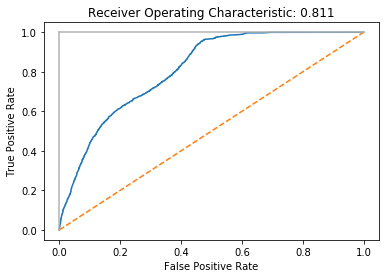

In [53]:
y_pred_proba2_train = search.predict_proba(X_train2)[:,1]

# Create true and false positive rates
print('***XGB-train***')
fpr2, tpr2, threshold = roc_curve(y_train2, y_pred_proba2_train)
plot_roc_curve(fpr2, tpr2, y_train2, y_pred_proba2_train)

***XGB-test***


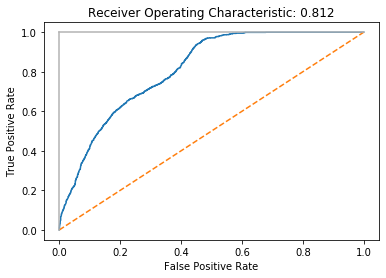

In [55]:
y_pred_proba2 = search.predict_proba(X_test2)[:,1]

# Create true and false positive rates
print('***XGB-test***')
fpr2, tpr2, threshold = roc_curve(y_test2, y_pred_proba2)
plot_roc_curve(fpr2, tpr2, y_test2, y_pred_proba2)

Given that the results above were already slightly lower than the ones for the previous dataset, it's not a surprise that the AUC acores and ROC Curve also display a lower performance. Again, both curves for the training and testing datasets have a similar AUC score. In some cases, this could indicate that the model is underfitting and a more complex one could help bring performance up.

So that we have a comparison with the model trained for `BOGO` and `discount` offers, the feature importance of the `xgboost` is plotted below. Here we can see the the sum of the viewed offers also seem to be among the most important features, along with the mean and sum of amount spent by each customer. In contrast gender `M` here has a higher importance, albeit not very high still. Income once again ranks higher in the list.

Not surprisingly, `sum_event_offer_completed` scores zero, as no informational offer could be "completed". In other words, all have the constant value of `0`. Along with it, email channel again ranks very low (no importance given by the model), along with other gender variables.

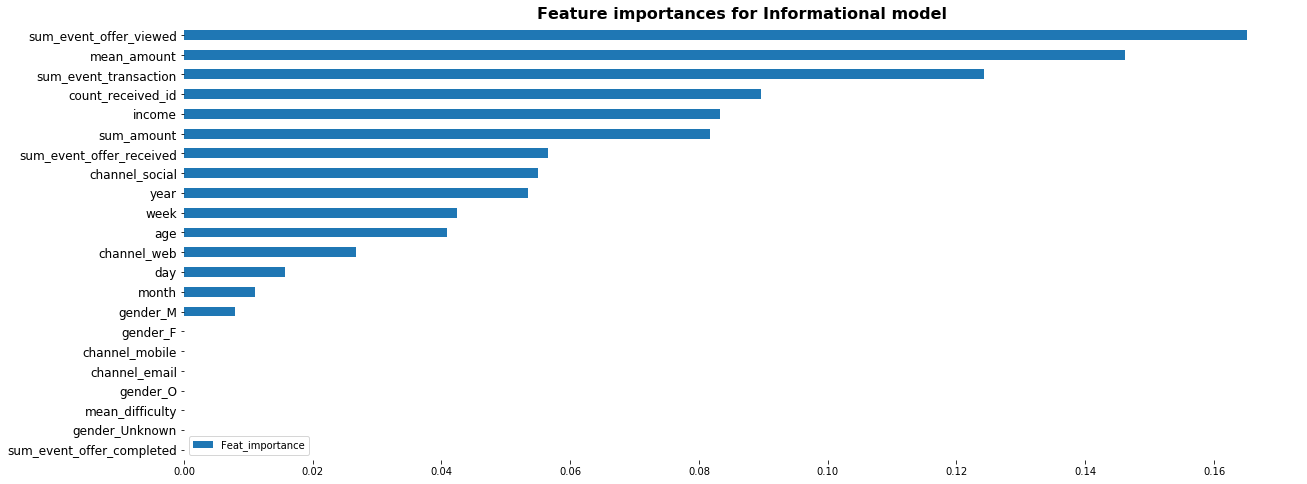

In [26]:
plot_feature_importances(search2, data=X_train2, tit="Feature importances for Informational model")

In [74]:
# Saving the model
filename = 'models/informational_model.sav'
pickle.dump(search2, open(filename, 'wb'))

filename_svc = 'models/informational_model_svc.sav'
pickle.dump(search_svc.best_estimator_, open(filename_svc, 'wb'))

In [76]:
# Loading the model
filename = 'models/informational_model.sav'
search2 = pickle.load(open(filename,'rb'))
search2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=10, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=nan, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [77]:
# Loading the model
filename_svc = 'models/informational_model_svc.sav'
search_svc = pickle.load(open(filename_svc,'rb'))
search_svc

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Conclusions

After an initial attempt of **predicting if an offer will be successful**, this appears to be a feasible task with the data available. Given demographic and offer characteristics, as well as behavioral data, the models seem to offer reasonable performances. This is specially true for the one trained with the `BOGO` and `discount` offer data. In this case, the model performs fairly good in predicting who would likely act upon one of this offers, by being actively engaged with the company. Once again, in order for these offers to be considered successful, the following criteria must be met:
- **BOGO & discount offers:** for these offers to be considered successful, these events need to happen in sequence:
- > **offer received >> offer viewed >> transaction >> offer completed**

Only if these events take place in sequence for the same offer, we will consider it successful (positive case). In this scenario, the best classifier was optimized and it yielded an ROC score of over 0.91, which is fairly high and could be used in a real life situation for such a task. Important to note here that sending promotional offers to customers does not require the same level of performance that a ML-model trained for a medical application for example, as a certain level of mistakes (customer don't act upon the offer) is unlikely to hurt the company by much.

Other metrics for this case are:
- accuracy score: 0.8296
- f1_score: 0.7853


On the dataset, the one containing `informational` offers, the classifiers also show a good performance, however slight lower than the previous case.
The results were:
- accuracy score: 0.7930
- f1_score: 0.7438


For this case the overall 

- **informational offer:** in this case we will need to observe the following:
- > **offer received >> offer viewed >> transaction**


The optimized classifiers produced results that are only slightly better, which could indicate that potential improvements in 3 main areas:
- feature engineering and preprocessing: more often than not, this is the area that mostly improves a model's performance. Nowadays, the algorithms are so optimized that data scientists spend most of their time engineering the data so that new features can increase the model's metrics. Some examples could be different feature representations (binning, scaling, polynomials, derived features, feature selection, etc.)
- wider parameter spaces: another topic is to tune the model with wider (or with mode combinations of) parameter ranges. Some can greatly improve if properly tunned, but even the ones that are more robust to parameter settings can improve with it. Therefore, this is a must for every model built.
- other models: each algorithm has it's own way of reaching conclusions and there is not a particular way that will solve all problems better. So, additional models can potentially show better performances.

These areas could be explored for further improvements in the results, but overall the goal of **predicting if an offer will be successful given customer demographic information, as well as some of the offer's characteristics** is not only feasible, but the classifiers trained here show that the features have a great discriminatory power to support the task.